In [48]:
import os
import tifffile
import numpy as np
from phathom.segmentation import segmentation as seg
from phathom.phenotype.frangi import frangi
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/tractography'

In [44]:
map2_dir = os.path.join(working_dir, '20190130_ctrl/map2_bm3d')

files = sorted(os.listdir(map2_dir))
len(files)

625

In [45]:
img = tifffile.imread([os.path.join(map2_dir, f) for f in files])
img.shape

(625, 2386, 2406)

<IPython.core.display.Javascript object>


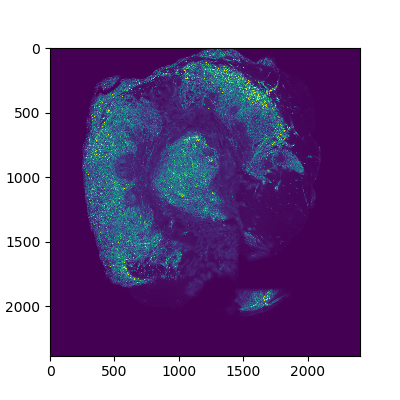

In [46]:
plt.figure(figsize=(4, 4))
plt.imshow(img[300])
plt.show()

In [7]:
help(frangi.frangi)

Help on function frangi in module phathom.phenotype.frangi.frangi:

frangi(nd_array, scale_range=(1, 10), scale_step=2, alpha=0.5, beta=0.5, frangi_c=500, black_vessels=True)



In [84]:
subimg = img[300:316].astype(np.float32)/4095

In [42]:
img_frangi = frangi.frangi(subimg, 
                           scale_range=(1, 3),
                           alpha=0.5,
                           beta=0.5,
                           frangi_c=50,
                           black_vessels=False)

<IPython.core.display.Javascript object>


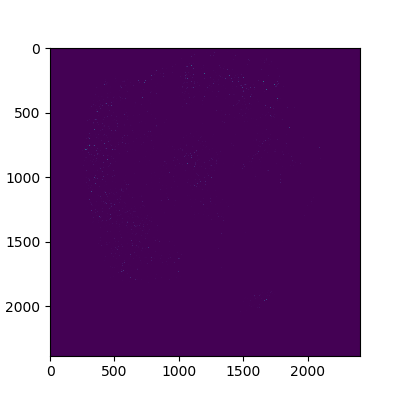

In [47]:
plt.figure(figsize=(4, 4))
plt.imshow(img_frangi[2])
plt.show()

In [129]:
g = seg.gaussian(subimg, sigma=(0.7, 1.0, 1.0))

In [130]:
img_grad = seg.gradient(g, 2, 1, 1)
img_grad.shape

(16, 2386, 2406, 3)

In [131]:
S = seg.hessian(g)
S.shape

(16, 2386, 2406, 3, 3)

In [132]:
eigvals = np.linalg.eigvalsh(S)
eigvals.shape

(16, 2386, 2406, 3)

<IPython.core.display.Javascript object>


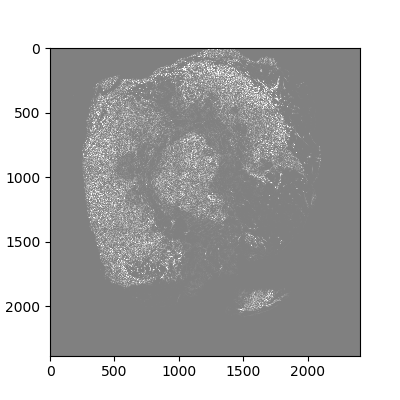

In [139]:
plt.figure(figsize=(4, 4))
# plt.imshow(subimg[4])
plt.imshow(-eigvals[4, ..., 0], cmap='gray', alpha=0.5, clim=[0, 0.1])
plt.show()

In [140]:
t1 = eigvals[..., 2]
t2 = eigvals[..., 1]
t3 = eigvals[..., 0]
t1.shape

(16, 2386, 2406)

In [122]:
N = t3**2 * 
D = t1**2 + t2**2 + t3**2
fa = np.sqrt(0.5*N/D)
fa.shape

/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(16, 2386, 2406)

In [104]:
N = (t1-t2)**2 + (t2-t3)**2 + (t3-t1)**2
D = t1**2 + t2**2 + t3**2
fa = np.sqrt(0.5*N/D)
fa.shape

/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(16, 2386, 2406)

<IPython.core.display.Javascript object>


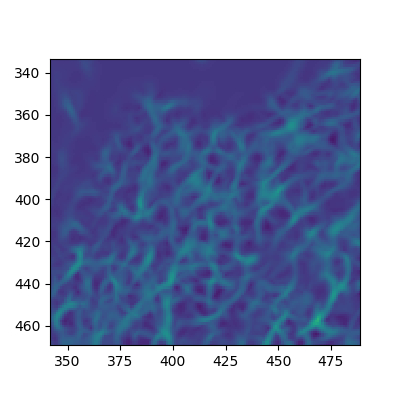

In [128]:
plt.figure(figsize=(4, 4))
plt.imshow(-t3[4])
plt.show()

Smallest eigenvalue of the hessian is a good way to enhance MAP2 fibers. Can normalize to 1 using an exponential decay with a parameter.

Need to turn this filtered image into a fiber segmentation and skeletonization

In [143]:
tifffile.imsave(os.path.join(working_dir, 'ridge.tif'), t3.astype(np.float32), compress=1)

<IPython.core.display.Javascript object>


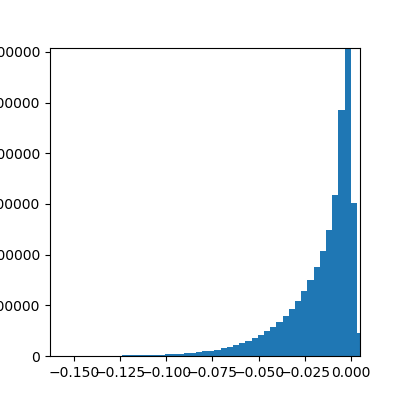

In [144]:
plt.figure(figsize=(4, 4))
plt.hist(t3.ravel(), bins=100)
plt.show()

In [155]:
prob = 1 - np.exp(-t3**2 / (4*t3.std()**2))

<IPython.core.display.Javascript object>


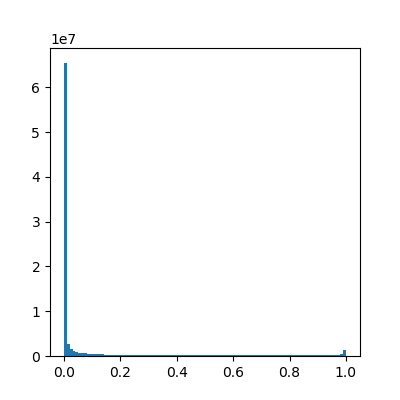

In [156]:
plt.figure(figsize=(4, 4))
plt.hist(prob.ravel(), bins=100)
plt.show()

In [157]:
tifffile.imsave(os.path.join(working_dir, 'ridge.tif'), prob.astype(np.float32), compress=1)

Note to future self: "skan" is a python package for skeleton analysis
use this with skeletonization from skimage to get branch length statistics
Also, render the fiber segmentation in Imaris